In [1]:
import pandas as pd
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import plotly.graph_objects as go
import ruptures as rpt
from itertools import combinations as comb
from statsmodels.stats import power
import numpy as np

from IPython.display import display
pd.set_option('display.max_rows', None)
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from scipy.spatial.distance import cdist
import colorsys


In [2]:
folder_path = 'data'
def read_data(filename):
    accelerometer = pd.read_csv(os.path.join(folder_path, filename, 'Accelerometer.csv'),sep=';')
    accelerometer['Time (s)'] = pd.to_datetime(accelerometer['Time (s)'], unit='s')
    accelerometer =accelerometer.set_index('Time (s)')
    accelerometer = accelerometer.resample('2.5ms').mean()
    accelerometer.rename(columns={'Acceleration x (m/s^2)':'accelerometer_x','Acceleration y (m/s^2)':'accelerometer_y','Acceleration z (m/s^2)':'accelerometer_z'}, inplace=True)
    accelerometer =accelerometer[9000:-9000]
    accelerometer.reset_index(inplace=True)

    gyroscope = pd.read_csv(os.path.join(folder_path, filename,'Gyroscope.csv'),sep=';')
    gyroscope['Time (s)'] = pd.to_datetime(gyroscope['Time (s)'], unit='s')
    gyroscope =gyroscope.set_index('Time (s)')
    gyroscope = gyroscope.resample('2.5ms').mean()
    gyroscope.rename(columns={'Gyroscope x (rad/s)':'gyroscope_x','Gyroscope y (rad/s)':'gyroscope_y','Gyroscope z (rad/s)':'gyroscope_z'}, inplace=True)
    gyroscope = gyroscope[9000:-9000]
    gyroscope.reset_index(inplace=True)
    merged = pd.merge(accelerometer,gyroscope, on= 'Time (s)', how='inner')
    return merged

In [3]:
# regex to delete the number at the end of the string:
def delete_number(string):
    return ''.join([i for i in string if not i.isdigit()])

In [4]:
data_dict = {}
name_to_idx = {} # name -> idx
i = 0

for name in os.listdir(folder_path):
    data_dict[name] = read_data(name)

    # add label
    if delete_number(name) in name_to_idx.keys():
        data_dict[name]['label'] = name_to_idx[delete_number(name)]
    else:
        name_to_idx[delete_number(name)] = i
        data_dict[name]['label'] = i
        i+=1

In [5]:
name_to_idx

{'chris': 0,
 'felix': 1,
 'till': 2,
 'nick': 3,
 'uta': 4,
 'paula': 5,
 'luisa': 6,
 'katarina': 7,
 'lucas': 8,
 'nele': 9}

In [6]:
verification_keys = ["nick2", "till2", "uta2", "paula2"]

In [7]:
def create_sliding_windows(data, window_length, stride, label):
    labels = np.ones(data.shape[0])*label
    num_windows = (len(data) - window_length) // stride + 1

    # Create sliding windows using numpy stride tricks
    windows = np.lib.stride_tricks.sliding_window_view(data, (window_length, data.shape[1]))
    windows = windows[::stride, 0, :, :]
    y_windows = labels[np.arange(0, num_windows * stride, stride)]  # Class labels at the start of each window

    return windows, y_windows

window_length = 100
stride = 200

X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []


for name, df in data_dict.items():
    if name in verification_keys:
        continue


    

    label = df['label'][0]

    df.drop(columns=['Time (s)','label'], inplace=True)

    train = df[:int(0.8*len(df))]
    # add normalization for training data
    train_normalized = (train - train.mean()) / train.std()

    test = df[int(0.8*len(df)):]

    test_normalized = (test - train.mean()) / train.std()   # normalize test data with training data mean and std


    X_train, y_train = create_sliding_windows(train, window_length, stride, label)
    X_test, y_test = create_sliding_windows(test, window_length, stride, label)
    
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10789, 100, 6), (10789,), (2696, 100, 6), (2696,))

In [9]:
n_samples, window_length, n_features = X_train.shape
X_train_reshaped = X_train.reshape(n_samples, window_length * n_features)
X_test_reshaped = X_test.reshape(X_test.shape[0], window_length * n_features)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_reshaped, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [10]:
y_pred = model.predict(X_test_reshaped)
y_pred_proba = model.predict_proba(X_test_reshaped)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("X_train shape:", X_train_reshaped.shape)
print("X_test shape:", X_test_reshaped.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Accuracy: 0.9562314540059347
X_train shape: (10789, 600)
X_test shape: (2696, 600)
y_train shape: (10789,)
y_test shape: (2696,)


In [11]:
report = classification_report(y_test, y_pred)

print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82       333
         1.0       1.00      0.98      0.99       304
         2.0       1.00      0.98      0.99       266
         3.0       0.97      1.00      0.99       690
         4.0       0.98      1.00      0.99       209
         5.0       1.00      0.93      0.96        95
         6.0       1.00      1.00      1.00       255
         7.0       0.68      1.00      0.81       186
         8.0       1.00      1.00      1.00       159
         9.0       1.00      1.00      1.00       199

    accuracy                           0.96      2696
   macro avg       0.96      0.96      0.95      2696
weighted avg       0.97      0.96      0.96      2696



In [12]:
y_pred_proba.min(), y_pred_proba.max()

(1.40320635e-08, 0.9999924)

# Verification with all second runs

In [13]:
X_verification_list = []
y_verification_list = []
for name, df in data_dict.items():
    if name in verification_keys:
        X_ver, y_ver = create_sliding_windows(df, window_length, stride)
        X_verification_list.append(X_ver)
        y_verification_list.append(y_ver)
X_verification = np.concatenate(X_verification_list, axis=0)
y_verification = np.concatenate(y_verification_list, axis=0)

TypeError: create_sliding_windows() missing 1 required positional argument: 'label'

In [ ]:
n_samples, window_length, n_features = X_verification.shape
X_verification = X_verification.reshape(n_samples, window_length * n_features)

In [ ]:
y_pred_ver = model.predict(X_verification)
y_pred_proba_ver = model.predict_proba(X_verification)
accuracy = accuracy_score(y_pred_ver, y_verification)
accuracy

0.5972620887613159

In [ ]:
report = classification_report(y_verification, y_pred_ver)

print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.81      0.92      0.86      1277
           3       0.49      0.98      0.65      1050
           4       0.81      0.02      0.04      1728
           5       0.99      0.98      0.99       474
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.60      4529
   macro avg       0.31      0.29      0.25      4529
weighted avg       0.76      0.60      0.51      4529



/home/nick/anaconda3/envs/wearables/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nick/anaconda3/envs/wearables/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nick/anaconda3/envs/wearables/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Verification with Till2

In [ ]:
X_verification, y_verification = create_sliding_windows(till2, window_length, stride)
n_samples, window_length, n_features = X_verification.shape
X_verification = X_verification.reshape(n_samples, window_length * n_features)

In [ ]:
y_pred_ver = model.predict(X_verification)
y_pred_proba_ver = model.predict_proba(X_verification)
accuracy = accuracy_score(y_pred_ver, y_verification)

In [ ]:
y_pred_proba_ver.min(), y_pred_proba_ver.max()

(5.1532616e-08, 0.99995875)

In [ ]:
accuracy

0.9381362568519969

<Axes: >

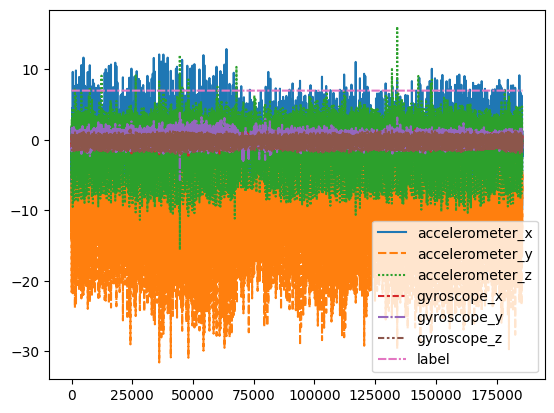

In [ ]:
sns.lineplot(data_dict["katarina1"])

In [ ]:
# def check_leakage(X_train, X_test, tol=1e-100):
#     # Check if any instance in the test set is present in the training set
#     for test_instance in X_test:
#         dists = np.linalg.norm(X_train - test_instance, axis=1)
#         if dists.min() < tol:
#             return True

#     # For time series data, check if any subsequence of the test set is present in the training set
#     for test_instance in X_test:
#         for i in range(X_train.shape[0] - len(test_instance) + 1):
#             if np.allclose(X_train[i:i+len(test_instance)], test_instance, atol=tol):
#                 return True

#     return False

# leakage_exists = check_leakage(X_train_reshaped, X_test_reshaped)
# print(f"Leakage exists: {leakage_exists}")